<center>
    <h1>02467 Computational Social Science</h1>
    <h2>Project Assignment</h2>
    <br><br>
    07-05-2021<br><br>
    Karl Byberg Ulbæk, s183931<br>
    Mads Lentoft, s183919
</center>

# Motivation
We have gathered reviews from 73 different points of interests (POI) in Copenhagen. With these reviews, we can perform some text analysis and construct networks with the POIs as nodes and the reviewers visitation behaviour as links inbetween.

We chose this as it seemed relevant to the pandemic slowly calming down and summer being very close, which makes it a perfect opportunity to take a look at places to visit.

Our goal is to answer if there is a difference in the places that local people and tourists visit, and if it affects how well they perceive the city. Do tourist rate POIs lower than locals do? Could this be because they only visit popular and potentially crowded places? If these cases are true, it could potentially be beneficial to put more focus on other places than those of most popularity. Nevertheless, these are questions we will try to answer in this project.

## Work distribution
Karl has primarily worked on data preparation and network analysis.
Mads has primarily worked on pre-analysis and text analysis.
Both participants have otherwise worked equally.

In [1]:
import pandas as pd
import os

# Loading the data and preproccesing
The data has been downloaded into 7 CSV. A cross all CSVs we have a total of 73 different attractions and 60.000+ different views. For each review we have the attributes: id_review, caption, relative_date,retrieval_date, rating,username, n_review_user, n_photo_user, url_user, url_source. Only caption (what was writtin in the review), rating and username are of interest.
We start out by joining all the CSVs into one dataframe and add another column to the dataframe which will be the attraction. The attraction information can be extracted from the url_source attribute.

In [2]:
# a helper function used in load_raw_csvs 
# which extracts the attraction from the url_scource attribute
def get_attraction(df_raw):
    attractions = []
    urls = df_raw["url_source"].values

    for i, url in enumerate(urls):
        dashes_counter = 0
        attraction_str = ""
        try:
            for letter in url:
                if letter == "/":
                    dashes_counter += 1

                if dashes_counter == 5:
                    attraction_str += letter

                if dashes_counter == 6:
                    attractions.append(attraction_str[1:])
                    break

        except TypeError:
            #print("the url was mostlikely a nan?:", url)
            attractions.append("unknown")

    attractions_corrected = []
    for atr in attractions:
        atr = atr.replace("%C3%A6", "æ")
        atr = atr.replace("%C3%86", "Æ")

        atr = atr.replace("%C3%B8", "ø")
        atr = atr.replace("%C3%98", "Ø")

        atr = atr.replace("%C3%A5", "å")
        atr = atr.replace("%C3%85", "Å")

        atr = atr.replace("SMK %E2%80%93 ", "")

        atr = atr.replace("+", " ")
        atr = atr.replace("\'", "")
        attractions_corrected.append(atr)


    return attractions_corrected


In [3]:
def load_raw_csvs(data_dir:str="data", load_merged_data:bool = False):

    if load_merged_data:
        print("raw_merged_data.csv was loaded from stashed data file")
        return pd.read_csv(os.path.join(data_dir,"raw_merged.csv"))
    print("Remaking raw_merged_data.csv. This should only take a few seconds.")
    csv_files = sorted(os.listdir(data_dir))

    for csv_file in csv_files:
        if csv_file.endswith(".csv") and csv_file.startswith("newest_gm_reviews"):
            if not 'df' in locals():
                df = pd.read_csv(os.path.join(data_dir, csv_file), error_bad_lines=False)
            else:
                df = df.append(pd.read_csv(os.path.join(data_dir, csv_file), error_bad_lines=False), ignore_index = True)

    df["attraction"] = get_attraction(df)
    df = df[df.attraction != "unknown"]

    df.to_csv(os.path.join(data_dir,"raw_merged.csv"), index=False)
    return df

In [4]:
#We test the load function where the data has the extra attraction column aswell
load_raw_csvs(load_merged_data=True).head()

raw_merged_data.csv was loaded from stashed data file


,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,attraction
0,ChZDSUhNMG9nS0VJQ0FnSUR5eTZXU0Z3EAE,(Translated by Google) Very exciting place. Lo...,3 weeks ago,2021-04-14 14:26:56.349032,5.0,Jesper Stentoft,0.0,0.0,https://www.google.com/maps/contrib/1173068539...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox
1,ChdDSUhNMG9nS0VJQ0FnSUR5dnQydThnRRAB,NaN,a month ago,2021-04-14 14:26:56.349032,4.0,Henrik Bech,9.0,0.0,https://www.google.com/maps/contrib/1094549896...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox
2,ChZDSUhNMG9nS0VJQ0FnSUR5dklYeE5nEAE,Copenhagen light festival. It’s simply excitin...,a month ago,2021-04-14 14:26:56.349032,5.0,Tech Research,0.0,0.0,https://www.google.com/maps/contrib/1094632797...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox
3,ChZDSUhNMG9nS0VJQ0FnSUR5M0pHV0JREAE,Well...,a month ago,2021-04-14 14:26:56.349032,3.0,Hans-Henrik S. Hansen,0.0,0.0,https://www.google.com/maps/contrib/1075209440...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox
4,ChdDSUhNMG9nS0VJQ0FnSUR5dUt5THV3RRAB,"(Translated by Google) So easy to park, the ca...",a month ago,2021-04-14 14:26:56.349032,5.0,Inger Hansen,27.0,0.0,https://www.google.com/maps/contrib/1165013941...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox


## Cleaning the textdata (caption attraibute) and dectecting nationality
All the captions have been translated to english if they were not already english. If they have been translated the caption in the original language will be present aswell. Inorder to classify the nationality of the reviwer we use language detection on the original languge. If the caption is in english we keep it. If the caption has been translated from some language which is not Danish we only keep the translation. If the caption was originally in danish we only keep the orginal danish caption. After the nationality has been classified we can clean up the caption. We do this for both english and danish captions by:
* Tokenise the words
* Stem all words
* Remove all stopwords
* Remove special characters such as: , . / \ ' '- ( ) ! ?

We can now add the following columns to our data frame: 
* nationality 
* english - which is all the cleaned english captions
* danish - which is all the cleaned danish captions
* translated - which is whether or not the english caption was translated from another language (this can also be directly inferred from the nationality attribute)



In [5]:
!pip install langdetect
from langdetect import detect

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


danish_stopwords = stopwords.words("danish")
english_stopwords = stopwords.words("english")

english_stemmer = SnowballStemmer(language="english")
danish_stemmer = SnowballStemmer(language="danish")

     |████████████████████████████████| 981 kB 26.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993190 sha256=1a924fc64866476b8da3406eb6603a3636fae968bfaf0a1009f55ddc8d055f30
  Stored in directory: /root/.cache/pip/wheels/1e/80/23/0a24928ec3a3906ff5027f38d2fea824e7e97f2ba7c83d91e3
Successfully built langdetect
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# a helper function used in gen_language_data which cleans the captions
def clean_text(text, english = True, remove_stopwords = True, stem = True):

    if not isinstance(text, list):
        text = list(text)

    def stop_words_and_stem(word):
        if english:
            if remove_stopwords:
                if word in english_stopwords:
                    word = ""

            if stem:
                    word = english_stemmer.stem(word)

        else:
            if remove_stopwords:
                if word in danish_stopwords:
                    word = ""

            if stem:
                word = danish_stemmer.stem(word)

        return word


    new_text = []

    for idx, word in enumerate(text):
        word = word.lower()
        word = word.replace(",", "")
        word = word.replace(".", "")
        word = word.replace("\'", "")
        word = word.replace("\"", "")
        word = word.replace("`", "")
        word = word.replace("-", "")
        word = word.replace("(", "")
        word = word.replace(")", "")
        word = word.replace("/", "")
        word = word.replace("[", "")
        word = word.replace("]", "")
        word = word.replace("/", "")
        word = word.replace("!", "")
        word = word.replace("?", "")
        word = stop_words_and_stem(word)
        if word != "":
            new_text.append(word)


    return new_text


In [7]:
def gen_language_data(df, load_data = False, num_words_to_use_for_lang_classification = 10):
    if load_data:
        print("Language_data.csv was loaded from stashed data file")
        return pd.read_csv("data/language_data.csv")

    print("Remaking language_data.csv. This will take some time...")
    df["caption"] = df["caption"].fillna("no-caption")

    captions = df["caption"].values


    captions = [caption.split(" ") for caption in captions]

    num_captions = df.shape[0]
    danish = ["0"]*num_captions
    english = ["0"]*num_captions
    nationality = ["0"]*num_captions
    translated = [False]*num_captions

    def get_progres(idx, steps, lenght):
        step_size = int(lenght/steps)
        if (idx+1) % step_size == 0:
            print(str(round((idx/lenght)*100))+"%")

    for idx, caption in enumerate(captions):
        get_progres(idx, 20, num_captions)

        # for some reason the text can be translated but the original text might not be included, which will result in an
        # error which is what we catch with the try except
        try:
            if caption != "no-caption":
                if (" ").join(caption[:3]) == "(Translated by Google)":
                    start_of_original = caption.index("(Original)")+1
                    caption_original = caption[start_of_original:]

                    try:
                        lang = detect((" ").join(caption_original[:num_words_to_use_for_lang_classification]))

                    except Exception:
                        lang = "unknown"
                        pass

                    nationality[idx] = lang

                    if lang == "da":
                        danish[idx] = clean_text(caption_original, english = False)

                    else:
                        english[idx] = clean_text(caption[3: start_of_original-1])
                        translated[idx] = True

                else:
                    try:
                        lang = detect((" ").join(caption[:num_words_to_use_for_lang_classification]))
                    except Exception:
                        lang = "unknown"
                        pass

                    if lang == "en":
                        english[idx] = clean_text(caption)
                        nationality[idx] = lang


        except ValueError:
            pass


    language_data = pd.DataFrame()
    language_data["english"] = english
    language_data["danish"] = danish
    language_data["nationality"] = nationality
    language_data["translated"] = translated

    language_data.to_csv("data/language_data.csv", index=False)

    return language_data




### Combining all the loading and data preprocessing functionallity into a single function

In [8]:
def get_all_data(remake_raw_data = False, remake_text_data = False):
    if not remake_raw_data and not remake_text_data:
        return pd.read_csv("data/complete_data_set.csv")

    if remake_raw_data:
        df_raw = load_raw_csvs(load_merged_data=False)
    else:
        df_raw = load_raw_csvs(load_merged_data=True)

    if remake_text_data:
        df_text_data = gen_language_data(df_raw, load_data=False)
    else:
        df_text_data = gen_language_data(df_raw, load_data=True)

    df_combined = df_raw.copy()
    for column in df_text_data.columns:
        df_combined[column] = df_text_data[column]

    df_combined.to_csv("data/complete_data_set.csv")
    return df_combined

In [9]:
get_all_data().head()

/shared-libs/python3.8/py-core/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,attraction,english,danish,nationality,translated
0,0,0,0,ChZDSUhNMG9nS0VJQ0FnSUR5eTZXU0Z3EAE,(Translated by Google) Very exciting place. Lo...,3 weeks ago,2021-04-14 14:26:56.349032,5.0,Jesper Stentoft,0.0,0.0,https://www.google.com/maps/contrib/1173068539...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox,0,"['spænd', 'sted', 'lækkert', 'miljø']",da,False
1,1,1,1,ChdDSUhNMG9nS0VJQ0FnSUR5dnQydThnRRAB,no-caption,a month ago,2021-04-14 14:26:56.349032,4.0,Henrik Bech,9.0,0.0,https://www.google.com/maps/contrib/1094549896...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox,0,0,0,False
2,2,2,2,ChZDSUhNMG9nS0VJQ0FnSUR5dklYeE5nEAE,Copenhagen light festival. It’s simply excitin...,a month ago,2021-04-14 14:26:56.349032,5.0,Tech Research,0.0,0.0,https://www.google.com/maps/contrib/1094632797...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox,"['copenhagen', 'light', 'festiv', 'it', 'simpl...",0,en,False
3,3,3,3,ChZDSUhNMG9nS0VJQ0FnSUR5M0pHV0JREAE,Well...,a month ago,2021-04-14 14:26:56.349032,3.0,Hans-Henrik S. Hansen,0.0,0.0,https://www.google.com/maps/contrib/1075209440...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox,0,0,0,False
4,4,4,4,ChdDSUhNMG9nS0VJQ0FnSUR5dUt5THV3RRAB,"(Translated by Google) So easy to park, the ca...",a month ago,2021-04-14 14:26:56.349032,5.0,Inger Hansen,27.0,0.0,https://www.google.com/maps/contrib/1165013941...,https://www.google.dk/maps/place/Blox/@55.6721...,Blox,0,"['så', 'nemt', 'park', 'bil', 'stod', 'sikkert...",da,False


# Pre-analysis
## Getting a sense of the data
We will take a few looks at how the locals and tourists are represented in our data, the width of the time span we have gathered, the ratings etc.

In [134]:
from matplotlib.ticker import PercentFormatter

def removeNanRows(dataframe, column):
    # Removes rows with nan using given column
    rows_to_remove = dataframe[dataframe[column].isna()].index
    print(f"Removed {len(rows_to_remove)} invalid rows\n")
    return dataframe.drop(rows_to_remove)

# Define the dataframe to use and prepare for pre-analysis
data = get_all_data()

#data = data.drop(["Unnamed: 0"], axis = 1)  # Removed potential duplicate index column
data = data.loc[:, ~df.columns.str.contains('^Unnamed')]
    
# Remove any invalid (NaN) rows using url_source
data = removeNanRows(data, "url_source")

# Remove incomplete captions
data = data.drop(data[(data["caption"].str[:22] == "(Translated by Google)") & (data["caption"].str.contains("(Original)") == False)].index)

# Fix caption columns
data["danish"] = data["danish"].replace("0", np.nan)
data["danish"] = data["danish"].str[1:-1].str.replace(" ", "").str.replace("'", "").str.split(",")
data["english"] = data["english"].replace("0", np.nan)
data["english"] = data["english"].str[1:-1].str.replace(" ", "").str.replace("'", "").str.split(",")
data["nationality"] = data["nationality"].replace("0", np.nan)

/shared-libs/python3.8/py-core/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
Removed 0 invalid rows



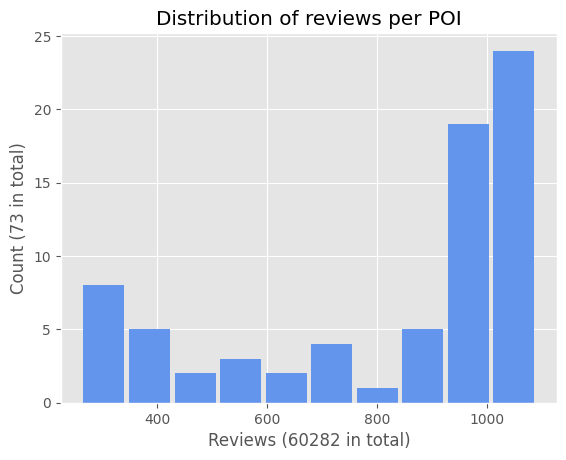

In [111]:
# Let's first look at the distribution of reviews per POI
data_hist = plt.hist(data.groupby(["attraction"]).size(), rwidth = 0.9, color = "cornflowerblue")
plt.title("Distribution of reviews per POI")
plt.xlabel(f"Reviews ({len(data)} in total)")
plt.ylabel(f"Count ({int(np.sum(data_hist[0]))} in total)")
max_neirest = int(data_hist[0].max() / 10 + 1) * 10
plt.yticks(np.arange(0, max_neirest, max_neirest / 6))
plt.savefig("figures/reviews_distribution.png")
plt.show()

As we are limited to ~1000 reviews, we see a cluster around that amount appear in the distribution. To have somewhat equal groups, we would have to consider the last and second last bin individually and the rest of the attractions collectively. This will be taken into consideration for the rest of the project.

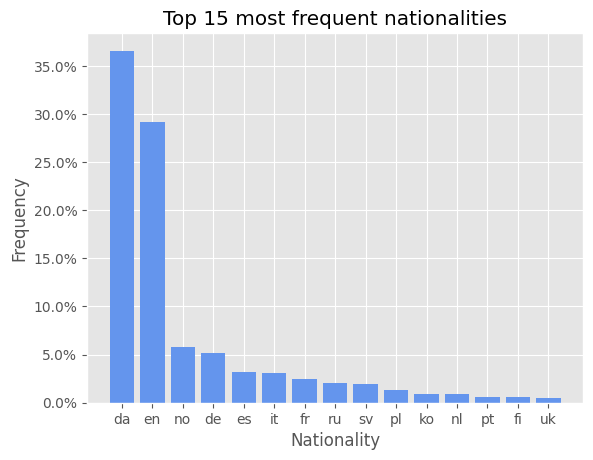

In [112]:
# Now see the distribution of nationalities
limit_nat = 15  # Set the amount of nationalities to look at

data_nat = data.groupby(["nationality"]).size()
data_nat = data_nat.sort_values(ascending = False)

plt.bar(np.arange(1, len(data_nat[:limit_nat]) + 1), data_nat.values[:limit_nat] / data_nat.sum(), color = "cornflowerblue")
plt.title(f"Top {limit_nat} most frequent nationalities")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))    # Fix y-axis, convert to %
plt.xticks(np.arange(1, len(data_nat[:limit_nat]) + 1), data_nat.index[:limit_nat])
plt.xlabel("Nationality")
plt.ylabel("Frequency")
plt.savefig("figures/distribution_nationalities")
plt.show()

From here we can see that Danish reviews account for about 1/3 of reviews with text and the rest of the nationalities total about 2/3.

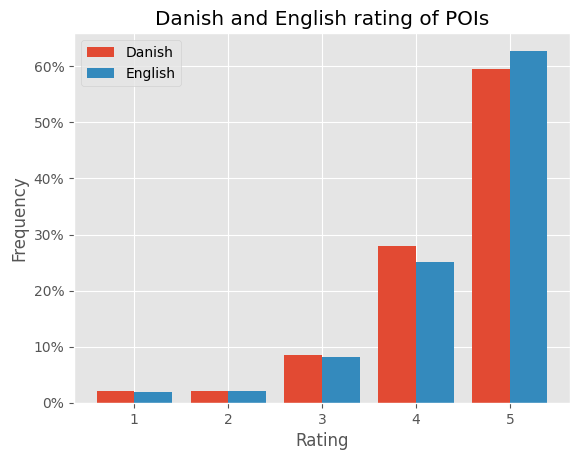

In [113]:
# Let's do some comparisons between danish and english ratings
plt.hist([data[data["nationality"] == "da"]["rating"], data[data["nationality"] == "en"]["rating"]], bins = np.arange(1, 7), density = True, label = ["Danish", "English"])
plt.title("Danish and English rating of POIs")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))    # Fix y-axis, convert to %
plt.xticks(np.arange(1, 6) + 0.5, np.arange(1, 6))          # Fix x-axis ticks
plt.legend()
plt.savefig("figures/ratings_da_en.png")
plt.show()

Here we see the initial ratings of the written reviews, we see that Danish reviews are generally lower than English. We will compare this distribution with sentiment later in the text analysis.

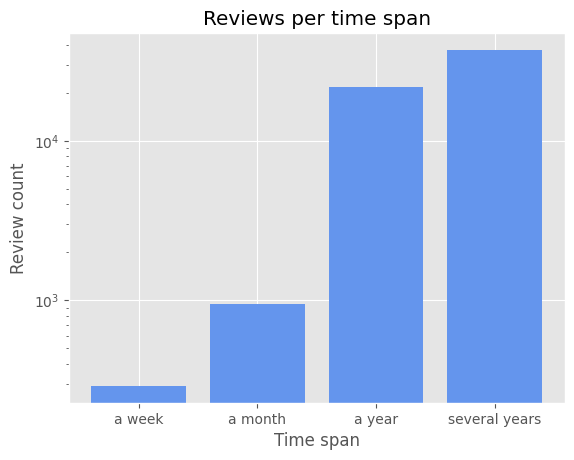

Percentage of reviews within 1 year:	38.13410304900302


In [153]:
# Taking a look at reviews over time
# Round the date up, hours become day, days become week etc.
data_time = data.copy(deep = True)

data_time.loc[data_time['relative_date'].str.contains('year'), 'relative_date'] = 'several years'
data_time.loc[data_time['relative_date'].str.contains('month'), 'relative_date'] = 'a year'
data_time.loc[data_time['relative_date'].str.contains('week'), 'relative_date'] = 'a month'
data_time.loc[data_time['relative_date'].str.contains('day'), 'relative_date'] = 'a week'
data_time.loc[data_time['relative_date'].str.contains('hour'), 'relative_date'] = 'a week'
data_time.loc[data_time['relative_date'].str.contains('minute'), 'relative_date'] = 'a week'

data_time = data_time.groupby(["relative_date"]).size()
time_order = ["a week", "a month", "a year", "several years"]

data_time = data_time.reindex(time_order)

plt.bar(data_time.index, data_time, log = True, color = "cornflowerblue")
plt.xlabel("Time span")
plt.ylabel("Review count")
plt.title("Reviews per time span")
plt.savefig("figures/distribution_time")
plt.show()

print(f"Percentage of reviews within 1 year:\t{(1 - data_time[-1]/np.sum(data_time))*100}")

Here we see that the majority of the reviews are from before the pandemic, where ~40% are from after the outbreak. Please note that the bars acts as bins, as for the tick "a month", it counts all reviews after "a week" and within "a month". They are not cumulative.

Taking the most recent reviews, we feared for the potential conflict of different preferences depending on when the review was made, as it would be assumed that sanitation and space had a much higher priority than previously. But as we see, a majority of reviews are from multiple years ago, with 38% of reviews being within 1 year.

# Text Analysis
## Looking between the lines
Here we look at what the reviews actually say and their sentiment. With this, we can compare it to the initial ratings.

In [296]:
# Load dependencies
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Prepare VADER for analysis
nltk.download("vader_lexicon")

analyzer = SentimentIntensityAnalyzer()

As a first step, we can construct a wordcloud of the tokens computed in the data preparation.

There are	68744	Danish tokens
There are	143523	English tokens


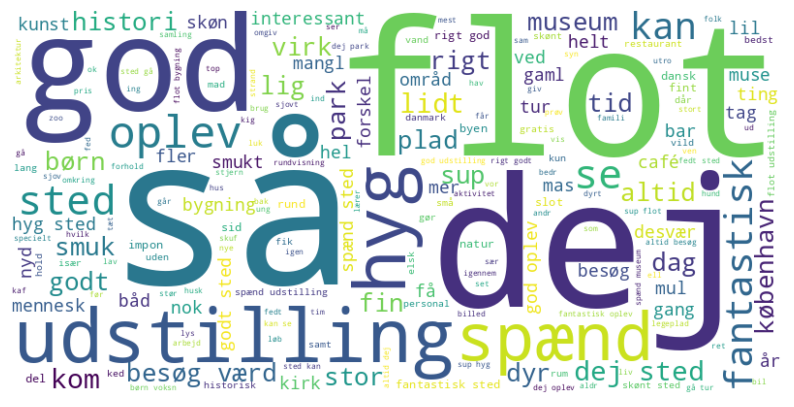

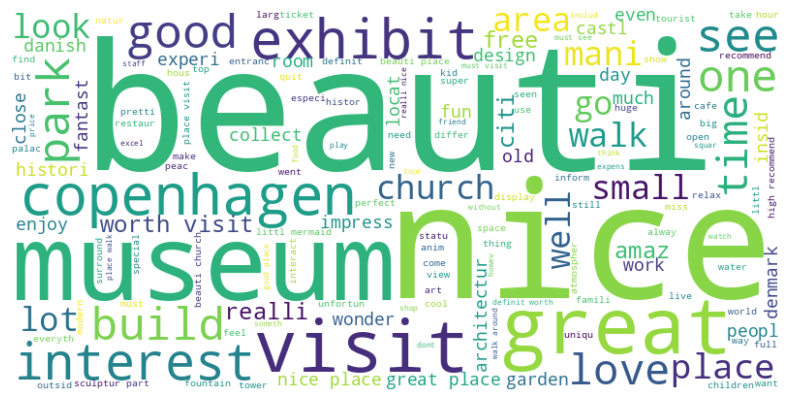

In [300]:
# Let's create documents with danish and english tokens
document_da = " ".join([item for sublist in data["danish"].dropna() for item in sublist])
document_en = " ".join([item for sublist in data["english"].dropna() for item in sublist])

# Let's take a look at the amount of tokens for each
print(f"There are\t{len(document_da.split(' '))}\tDanish tokens")
print(f"There are\t{len(document_en.split(' '))}\tEnglish tokens")

wordcloud_da = WordCloud(background_color = "white", scale = 2).generate(document_da)
wordcloud_en = WordCloud(background_color = "white", scale = 2).generate(document_en)

# Show the wordclouds
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_da, interpolation = "bilinear")
plt.axis("off")
wordcloud_da.to_file("figures/wordcloud_da.png")
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_en, interpolation = "bilinear")
plt.axis("off")
wordcloud_en.to_file("figures/wordcloud_en.png")
plt.show()

We get a wordcloud with frequent tokens of adjectives such as beautiful, nice, great. But we also get speficic locations tokens such as museum, exhibit, church, park. As we are dealing with locations and reviews of mostly positive rating, these tokens are not really surprising to us.

In [174]:
# Method for extracting translated string
def getTranslatedCaption(caption):
    starter = "(Translated by Google)"
    stopper = "(Original)"
    i_start = caption.find(starter) + len(starter)
    i_stop = caption.find(stopper)
    return caption[i_start:i_stop].strip()

In [181]:
def getSentiments(captions, useTranslated = False):
    # Takes a list of captions and returns a list of their sentiments
    sentiments = []
    for caption in captions:
        if useTranslated:
            score = analyzer.polarity_scores(getTranslatedCaption(caption))
        else:
            score = analyzer.polarity_scores(caption)
        sentiments.append(score["compound"])
    return sentiments
    

In [200]:
sentiments_da = getSentiments(data[data["nationality"] == "da"]["caption"], useTranslated = True)
sentiments_en = getSentiments(data[data["nationality"] == "en"]["caption"])

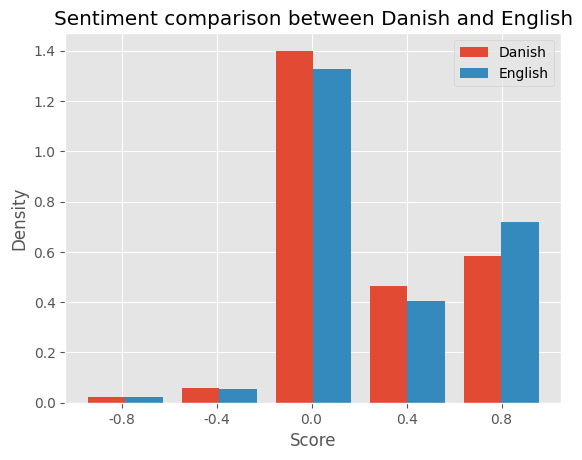

In [228]:
plt.hist([sentiments_da, sentiments_en], density = True, bins = 5, label = ["Danish", "English"])
plt.title("Sentiment comparison between Danish and English")
plt.xlabel("Score")
plt.ylabel("Density")
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))    # Fix y-axis, convert to %
plt.xticks(np.linspace(-1, 1, 5) * 0.8, np.linspace(-1, 1, 5) * 0.8)          # Fix x-axis ticks
plt.legend()
plt.savefig("figures/sentiment_da_en.png")
plt.show()

From what we can see, the Danish reviews are more neutral while the English are more positive. Let's try and compare this with the intial ratings of the written reviews

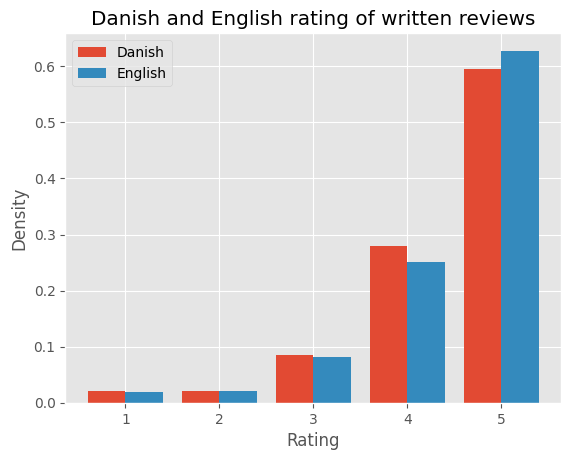

In [256]:
# Let's do some comparisons between danish and english ratings
plt.hist([data[(data["nationality"] == "da") & (data["caption"].notna())]["rating"], data[(data["nationality"] == "en") & (data["caption"].notna())]["rating"]], density = True, bins = np.arange(1, 7), label = ["Danish", "English"])
plt.title("Danish and English rating of written reviews")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.xticks(np.arange(1, 6) + 0.5, np.arange(1, 6))          # Fix x-axis ticks
plt.legend()
plt.savefig("figures/ratings_written_da_en.png")
plt.show()

If we look at the highest and second higest scores, they match in rating and sentiment, but as we look at the neutral score, we find a major difference, as we see a lot more reviews in this area. As for the lower scores, they appear to match relatively well with the ratings.

From what we can see, a lot of people leave a positive rating and keep their sentiment neutral. However, this is limited by the accuracy of the VADER analyzer, and a majority of captions being netural doesn't say much. What is important to note is similarity between positive scores/ratings and negative scores/ratings.

We can take a further look and compare sentiment within the top 15 nationalities.

In [235]:
data_sentiment = data[data["nationality"].notna()][["caption", "rating", "nationality"]].copy(deep = True)

sentiments = []

for i in range(len(data_sentiment)):
    row = data_sentiment.iloc[i]
    if (row["nationality"] == "en"):
        sentiments.append(getSentiments([row["caption"]])[0])
    else:
        sentiments.append(getSentiments([row["caption"]], useTranslated = True)[0])

data_sentiment["score"] = sentiments

In [280]:
# Group the ratings and score per nationality and order them by count
data_grouped_sentiment = data_sentiment.groupby("nationality").agg(count=('rating', 'size'), mean_rating=('rating', 'mean'), mean_score=('score', 'mean')).sort_values(by = "count", ascending = False)

In [281]:
# We should normalize ratings and scores
# Ratings are between 1 to 5 and scores -1 to 1, we want both from 0 to 1
data_grouped_sentiment["mean_rating"] = (data_grouped_sentiment["mean_rating"] - 1) / 4
data_grouped_sentiment["mean_score"] = (data_grouped_sentiment["mean_score"] + 1) / 2

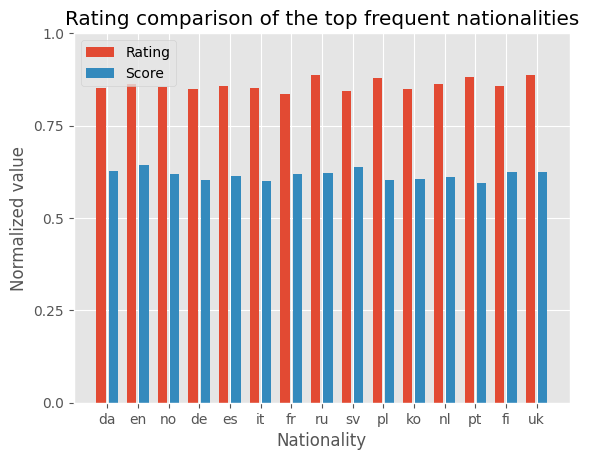

Min values of data:
count          3.000000
mean_rating    0.750000
mean_score     0.496875
dtype: float64

Max values of data:
count          8035.000000
mean_rating       1.000000
mean_score        0.762325
dtype: float64


In [293]:
#plt.bar(np.arange(1, len(data_grouped_sentiment["mean_rating"][:limit_nat]) + 1) - 0.2, data_grouped_sentiment["mean_rating"][:limit_nat])
#plt.bar(np.arange(1, len(data_grouped_sentiment["mean_score"][:limit_nat]) + 1) + 0.2, data_grouped_sentiment["mean_score"][:limit_nat])

plt.bar(np.arange(1, limit_nat + 1) - 0.2, data_grouped_sentiment["mean_rating"][:limit_nat], width = 0.3, label = "Rating")
plt.bar(np.arange(1, limit_nat + 1) + 0.2, data_grouped_sentiment["mean_score"][:limit_nat], width = 0.3, label = "Score")
plt.title(f"Rating comparison of the top frequent nationalities")
plt.xticks(np.arange(1, len(data_nat[:limit_nat]) + 1), data_nat.index[:limit_nat])
plt.yticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5))
plt.xlabel("Nationality")
plt.ylabel("Normalized value")
plt.legend()
plt.savefig("figures/sentiment_ratings_nationality.png")
plt.show()

print("Min values of data:")
print(data_grouped_sentiment.min())
print("\nMax values of data:")
print(data_grouped_sentiment.max())

From a first observation, we see that when normalized, the ratings are much higher than the sentiment scores. This was also the case previously when comparing Danish and English ratings/scores, where we discussed how the sentiment is generally neutral in the reviews, so this will lower the average score.

When comparing the different nationalities, they are all mostly positive, with no particular nationality differentiating themselves, as the small differences could be affected by the fewer number of reviews of that nationality, and it's possible that they all would have the same true mean.

# Network analysis 
## Turning our data into a network
We start out by turning our data into a network. Each attraction is a node and two nodes are connected by an edge if the same person has reviewed in other words visited both attractions. 
Each edge further gets a weight which corresponds to how many people have visited both attractions the given edge is connecting.
We will start out by representing the network as a dictionary where the key is a frozenset. The frozenset type ensures that the key ("Valby Park", "Round Tower") is the same as ("Round Tower", "Valby Park"). The dictionary value is the edge weight. Afterwards the dictionary can easily be turned into a network.


In [10]:
# a bunch of imports and helper functions
%pylab inline
import networkx as nx
import pickle
import matplotlib.image as mpimg
from netwulf import visualize
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def get_progres(idx, steps, lenght):
    step_size = int(lenght / steps)
    if (idx + 1) % step_size == 0:
        print(str(round((idx / lenght) * 100)) + "%")


def save_dict(dict_, file_name):
    temp_file = open("data/" + file_name + ".pkl", "wb")
    pickle.dump(dict_, temp_file)
    temp_file.close()


def load_dict(file_name):
    temp_file = open("data/" + file_name + ".pkl", "rb")
    return pickle.load(temp_file)


Populating the interactive namespace from numpy and matplotlib


In [42]:
def create_graph_dict(df=None, remake_dict=False, graph_dict_name="graph_dict_all"):
    if not remake_dict:
        #print("{}.pkl was loaded from stashed data file.".format(graph_dict_name))
        return load_dict(graph_dict_name)

    print("Remaking {}.pkl. This will take some time...".format(graph_dict_name))

    attractions = df["attraction"].values
    users = df["username"].values
    users_unique = set(users)
    users_unique_num = len(users_unique)

    attraction_connections = {}

    for idx, user in enumerate(users_unique):
        get_progres(idx, 10, users_unique_num)

        # find index of all occurrences of the user in all of the reviews
        links = [i for i, x in enumerate(users) if x == user]

        # if the user occur more than once we procede:
        if len(links) > 1:

            # create a set for seen combinations:
            combination_set = set()
            # we find all combinations of links
            for first_link in links:
                for second_link in links:
                    if first_link != second_link:
                        # we create the combination as a frozen set meaning that we can give it as an input to
                        # the dict where the order of the tuple (attraction1, attraction2) doesnt matter.
                        combination = frozenset((attractions[first_link], attractions[second_link]))

                        # if the combination doesnt exist we add it to the list of existing combinations and
                        # increment the attration dictionary
                        if combination not in combination_set:
                            combination_set.add(combination)
                            # we increment the dict for the given combination by 1, even if the entry doesnt exist
                            attraction_connections[combination] = attraction_connections.get(combination, 0) + 1

    # remove entries of people who has reviewed the same place twice
    for key in list(attraction_connections.keys()):
        if len(key) == 1:
            attraction_connections.pop(key)

    save_dict(attraction_connections, graph_dict_name)

    return attraction_connections

In [12]:
def make_graph_from_dict(graph_dict):
    G = nx.Graph()
    for atr, edge_weight in list(graph_dict.items()):
        atr = list(atr)
        atr1 = atr[0]
        atr2 = atr[1]
        G.add_edge(atr1, atr2, weight=edge_weight)

    return G

### We can now construct the full network. Visualized it looks as follows:

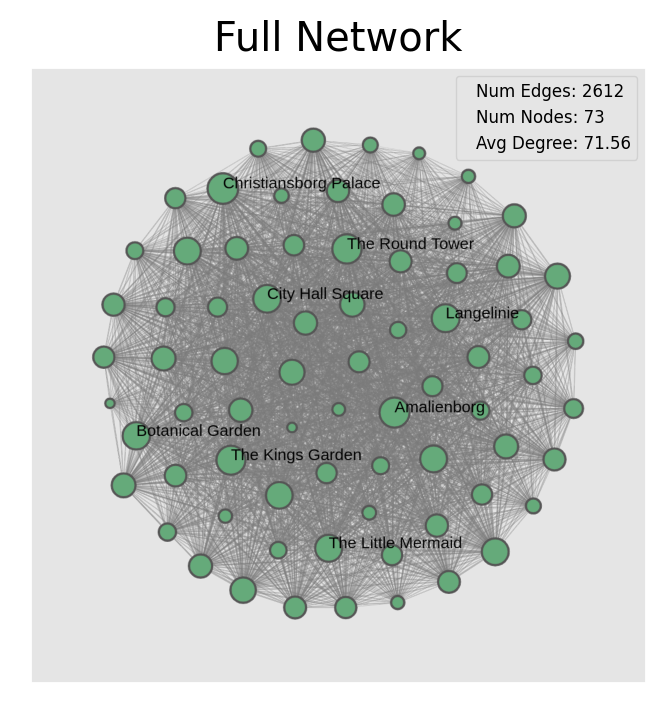

In [50]:
# funtion to only display top names in the network
def display_top_x_names(graph, graph_dict, top_x):
    degree_n_weigths = dict(graph.degree)
    for zet, val in list(graph_dict.items()):
        zet_list = list(zet)
        degree_n_weigths[zet_list[0]] += val*0.5
        degree_n_weigths[zet_list[1]] += val*0.5

    degree_n_weigths = list(degree_n_weigths.items())
    top_x_keeps_name = list(sorted(degree_n_weigths, key=lambda x: x[1], reverse=True))[:top_x]
    top_x_keeps_name = [name for name, val in top_x_keeps_name]
    rename_dict = {}
    empty = ""
    for key in list(graph.nodes):
        if key not in top_x_keeps_name:
            rename_dict[key] = empty
            empty += " "

    return nx.relabel_nodes(graph, rename_dict)

# function to safe the config file for the vizualation if we are interested
def visualize_with_config(g, graph_dict, redo_config = False, config_name="netwulf_config_all", top_x = None):
    if top_x is not None:
        g = display_top_x_names(g, graph_dict, top_x)
    if not redo_config:
        config = load_dict(config_name)
        visualize(g, config = config)
    else:
        _, config = visualize(g)
        save_dict(config, config_name)


# the actual function to display the network with netwulf
def visualize_network():
    graph_dict = create_sub_graph_dict(df=df, subset="international", remake_dict=True)
    full_network = make_graph_from_dict(graph_dict)
    visualize_with_config(full_network, 
                          graph_dict,
                          redo_config=False,
                          config_name="netwulf_config_all",
                          top_x=8,
                          color="int")

# visualize_network()

# this function will not be called since it cant output the visualizetion to
# the output-cell but rather the output is opened in a new browser tab. 
# Therefor we will just display pictures of already visualized networks.

def display_network(filename, title, graph_dict_name="graph_dict_all"):
    graph_dict = create_graph_dict(graph_dict_name=graph_dict_name)
    network = make_graph_from_dict(graph_dict)

    edges = str(len(list(network.edges)))
    nodes = str(len(list(network.nodes)))
    avg_degree = str(round(np.mean(np.asarray([val for node, val in list(network.degree)])),2))
    

    figure(figsize=(4, 4), dpi=200)
    img = mpimg.imread('networks/' + filename + '.png')
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(title)
    plt.plot([],[], label = "Num Edges: " + edges, color = "gray")
    plt.plot([],[], label = "Num Nodes: " + nodes, color = "gray")
    plt.plot([],[], label = "Avg Degree: " + avg_degree, color = "gray")
    plt.legend(prop={'size': 6}, handlelength=0)
    plt.savefig("networks/" + filename + "_plot.png")
    plt.show()
    
display_network("full_network", "Full Network", graph_dict_name = "graph_dict_all")




##### The node-names which have been displayed are the top 8 nodes with the highest amount of combined degree and edgeweights (a more precies definition will follow later). 
##### Not much can be inferred from the full network. More or less everything is connected. Besides, the full network wont show anything interesting in regards to the behavior of the locals versus the tourists. 

### Since we are interested in comparing the locals/Danes to the tourists/internationals we will create 2 networks, one for each group. 

Only reviews that acually have a caption can be classified as either danish or foreign. The following will reduce our data to only known nationalities, and display the network for each of those 2 groups.

In [53]:
# this function will scale the tourist dataset to match the size of the danish
# this function is not neeeded yet but has to "exists" just as a placeholder since
# create_sub_graph_dict can and will use it later on.
def normalize_df(df, desired_num_rows = 5000, normalized_comparison_to = "da"):
    # some code : )
    return normalized_df



# this function will create a graph dict for a subset of the data. For instance
# a nationality 
def create_sub_graph_dict(df=None, subset="all", remake_dict=False, normalized_comparison_to = None):
    if normalized_comparison_to != None:
        print("Creating/loading sub graph data dict with normalized international entries.")

        desired_num_rows = df[df.nationality == normalized_comparison_to].shape[0]
        print("This dataset is normalized to only have {} rows in order to match the number of rows in the {} "
              "dataset.".format(desired_num_rows, normalized_comparison_to))

        if remake_dict:
            df = df[df.nationality != normalized_comparison_to]
            df = df[df.nationality != "0"]
            df = normalize_df(df, desired_num_rows=desired_num_rows, normalized_comparison_to=normalized_comparison_to)

        return create_graph_dict(df,
                                 remake_dict=remake_dict,
                                 graph_dict_name="graph_dict_international_normalized_to_{}". \
                                 format(normalized_comparison_to))

    if subset == "all":
        print("Creating/loading graph data dict with all the data.")
        return create_graph_dict(df, remake_dict=remake_dict, graph_dict_name="graph_dict_all")

    if subset == "international":
        print("Creating/loading sub graph data dict with only international entries.")
        df = df[df.nationality != "0"]
        df = df[df.nationality != "da"]
        return create_graph_dict(df, remake_dict=remake_dict, graph_dict_name="graph_dict_international")

    if subset == "da":
        print("Creating/loading sub graph data dict with only {} entries.".format(subset))
        df = df[df.nationality == subset]
        print()
        return create_graph_dict(df, remake_dict=remake_dict, graph_dict_name="graph_dict_{}".format(subset))





Creating/loading sub graph data dict with only international entries.


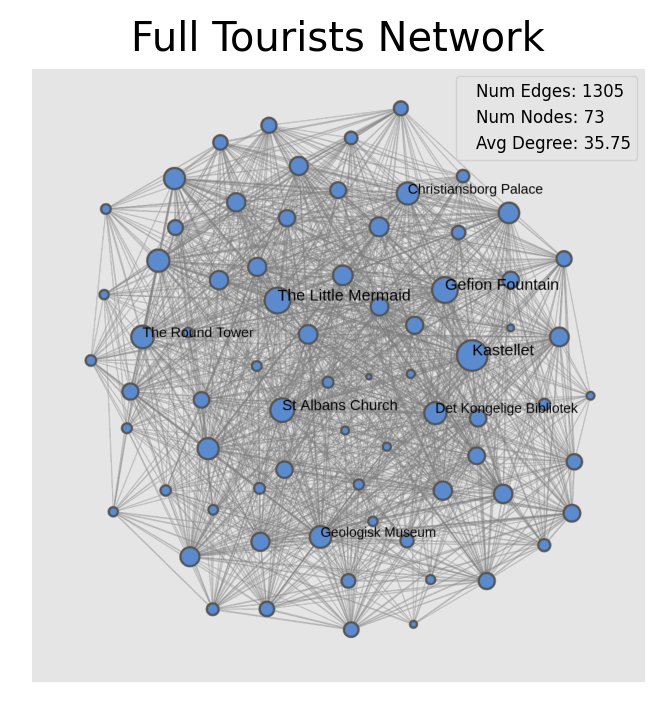

Creating/loading sub graph data dict with only da entries.



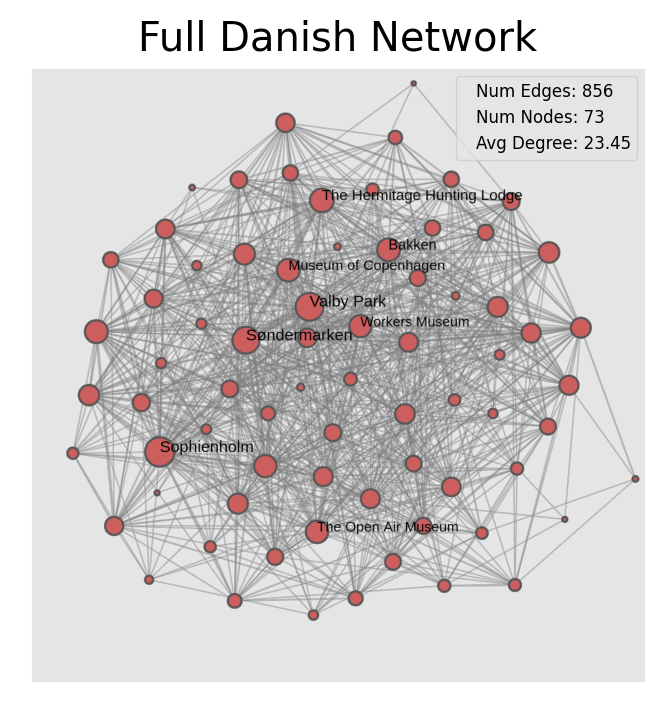

In [54]:
# the dict is not actually recreated since it takes some time and has already been done
graph_dict = create_sub_graph_dict(df, subset="international", remake_dict=False)
display_network("full_network_tou", 
                "Full Tourists Network", 
                graph_dict_name = "graph_dict_international")

# the dict is not actually recreated since it takes some time and has already been done
graph_dict = create_sub_graph_dict(df, subset="da", remake_dict=False)
display_network("full_network_da",
                "Full Danish Network",
                graph_dict_name = "graph_dict_da")



##### Its very clear that this it not a fair comparison. There is way more data for the tourists, which is why we will now normalize the tourist data such that it has as many entries as the danish. It will be done in such a way that whenever we pick one user to include in the normalized tourist dataset we will make sure to bring all entries of that user. The code to normalize the the tourist dataset has been implemented as a placeholder function earlier in the notebook. The proper code is as follows:

In [55]:
def normalize_df(df, desired_num_rows = 5000, normalized_comparison_to = "da"):
    num_rows = 0
    users = list(set(df.username))

    for user in users:
        if num_rows > desired_num_rows:
            break

        if num_rows == 0:
            normalized_df = df[df.username == user]
            num_rows += normalized_df.shape[0]

        else:
            temp_df = df[df.username == user]
            if normalized_comparison_to not in list(temp_df.nationality.values):
                normalized_df = normalized_df.append(temp_df, ignore_index=True)
                num_rows += temp_df.shape[0]

    if num_rows < desired_num_rows:
        print("the desired number of rows of {} was not reached. Only {} number of rows was created." \
              .format(desired_num_rows, num_rows))
    
    return normalized_df

##### The normalized tourist network looks as follows:

Creating/loading sub graph data dict with normalized international entries.
This dataset is normalized to only have 8037 rows in order to match the number of rows in the da dataset.


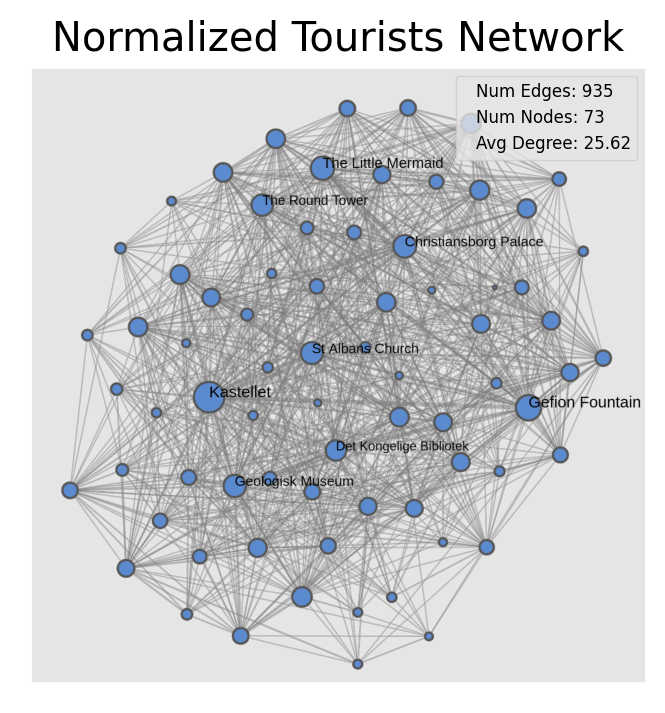

In [58]:
# the dict is not actually recreated since it takes some time and has already been done
graph_dict = create_sub_graph_dict(df, subset="international", remake_dict=False, normalized_comparison_to = "da")
display_network("full_network_tou_normalized_to_da", 
                "Normalized Tourists Network", 
                graph_dict_name = "graph_dict_international_normalized_to_da")

#### We see that both the normalized tourist network and the danish network has all 73 nodes/attractions present. From the avg degree/ num egdes we notice that the tourist network seems a bit more connected.

## A closer look at the comparison of the two networks. 
For good measure we will include a random network where it makes sence. This is to ensure that the patterns we are seeing are not just random. We will start out by plotting the most and least connected nodes for both networks based on a combined degree-edge-weight measure. When analysin the network we will not only use the degree but a combined degree-edge-weight measure. For a given node this will be equal to two times its degree plus the sum of the weights of all edges that connect to the node. The reason for this measure is to try and emphasis nodes that have a lot of connections (high degree) but also nodes which has strong connections (high edge weight) to other nodes.

In [61]:
# make an avg random graph based on a list of graphs
def make_random_graph(list_of_graphs, list_of_graph_dicts):
    if not isinstance(list_of_graphs, list):
        list_of_graphs = list(list_of_graphs)

    num_graphs = len(list_of_graphs)
    N,L,note_pairs = 0,0,0
    for graph in list_of_graphs:

        N_temp = len(graph.nodes)
        N += N_temp * (1/num_graphs)
        L += len(graph.edges) * (1/num_graphs)
        note_pairs += ((N_temp*(N_temp-1)) / 2) * (1/num_graphs)

    p = L / note_pairs
    G = nx.generators.random_graphs.erdos_renyi_graph(n=int(N), p=p, directed=False)
    renaming_dict = {item: key for item, key in zip(range(len(list(list_of_graphs[0].nodes))), list(list_of_graphs[0].nodes))}
    G = nx.relabel_nodes(G, renaming_dict)

    random_weights = []
    for dict_ in list_of_graph_dicts:
        random_weights+=list(dict_.values())

    random_graph_dict = {key: random.choice(random_weights) for key, _ in list(list_of_graph_dicts[0].items())}

    return G, random_graph_dict


In [289]:
def plot_graph_wight_n_degree(graph, graph_dict, name, color, weight_scaling=1, degree_scaling=2, top=7):

    degree_n_weigths = {key: val*degree_scaling for key, val in list(graph.degree)}
    for zet, val in list(graph_dict.items()):
        zet_list = list(zet)
        degree_n_weigths[zet_list[0]] += (val-1)*weight_scaling
        degree_n_weigths[zet_list[1]] += (val-1)*weight_scaling

    degree_n_weigths = list(degree_n_weigths.items())
    degree_n_weigths.sort(key=lambda x: x[1])

    fig, (ax2, ax1) = plt.subplots(1, 2)
    fig.subplots_adjust(bottom=0.3)
    ax2.plot([val for name, val in degree_n_weigths[:top]], color=color)
    ax2.set_xticks(list(range(top)))
    ax2.set_xticklabels([name[:20] for name, val in degree_n_weigths[:top]], rotation=70)
    ax2.set_title("Top {} lowest".format(top))

    degree_n_weigths.reverse()

    ax1.plot(list(reversed([val for name, val in degree_n_weigths[:top]])), color=color)
    ax1.set_xticks(list(range(top)))
    ax1.set_xticklabels(list(reversed([name[:20] for name, val in degree_n_weigths[:top]])), rotation=70)
    ax1.set_title("Top {} highest".format(top))
    fig.suptitle('Combined-weight-and-degree over {}'.format(name), fontsize=16)
    # fig.title("Most and least connected attractions")
    plt.show()

    return degree_n_weigths

Creating/loading sub graph data dict with normalized international entries.
This dataset is normalized to only have 8037 rows in order to match the number of rows in the da dataset.


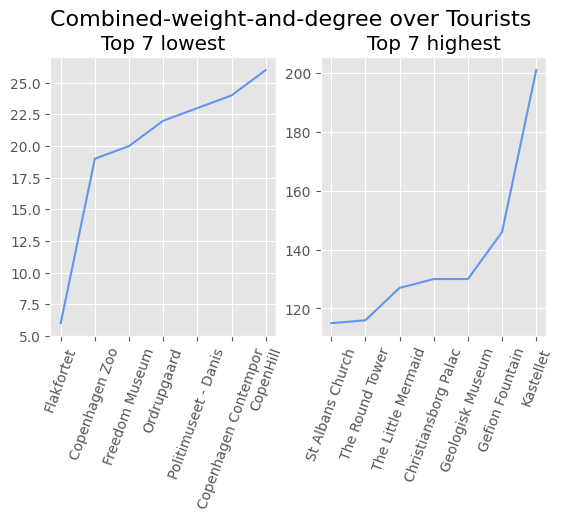

Creating/loading sub graph data dict with only da entries.



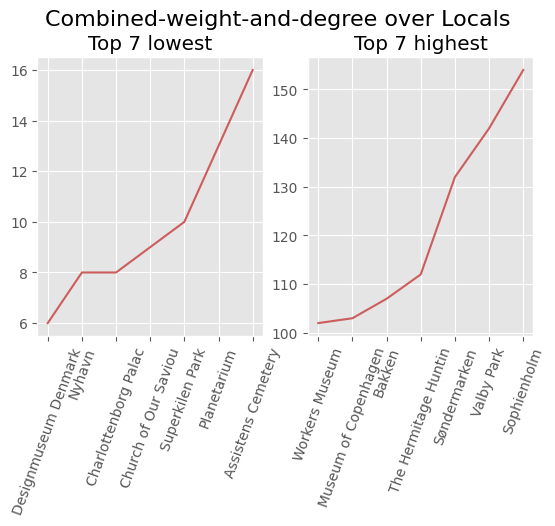

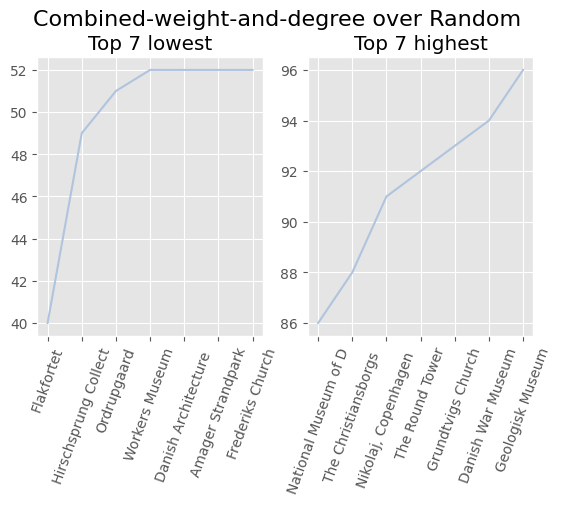

In [290]:
name_list = ["Tourists","Locals", "Random"]
color_list = ["cornflowerblue", "indianred", "lightsteelblue"]

#International
graph_dict_int = create_sub_graph_dict(df, remake_dict=False, subset="international", normalized_comparison_to="da")
G_int = make_graph_from_dict(graph_dict_int)
tourists_degrees = plot_graph_wight_n_degree(G_int, graph_dict_int, name = name_list[0], color=color_list[0])

# DANISH
graph_dict_da = create_sub_graph_dict(df, remake_dict=False, subset="da")
G_da = make_graph_from_dict(graph_dict_da)
locals_degrees = plot_graph_wight_n_degree(G_da, graph_dict_da, name = name_list[1], color=color_list[1])

# RANDOM
G_ran, graph_dict_ran = make_random_graph([G_da, G_int], [graph_dict_int, graph_dict_da])
random_degrees = plot_graph_wight_n_degree(G_ran, graph_dict_ran, name = name_list[2], color=color_list[2])


#### These results give some insigt to what the locals prefer versus the tourists. The random network should just be ignored for now. It is clear that they have very different preferences, and that the tourists prefer the famous, traditional and big attractions such as Christiansborg, The little Mermaid and the Round Tower, where as the danes prefer the more "local" and down to earth attractions such as Valby Park, Søndermarken and The Hermitage Hunting Lodge.

#### To more directly look at the attractions with the biggest interest difference we can plot the following:

In [291]:
def compare_all_degree(degree_list, name_list, color_list, sorted_by_attraction, hist = False):
    for degree, name, color, in zip(degree_list, name_list, color_list):
        if name == "Random" and sorted_by_attraction:
            break

        degree.sort(key=lambda x: x[1])

        if sorted_by_attraction:
            degree.sort(key=lambda x: x[0])
            #print(degree)

        vals = [val for attracktion, val in degree]
        if hist:
            min_val, max_val = min(vals), max(vals)
            hist_, bin_edges = np.histogram(vals, np.linspace(min_val, max_val, 15), density = True)
            bin_edges = bin_edges[:-1]
            plt.plot(bin_edges, hist_, label=name, color=color)
        else:
            plt.plot(vals, label=name, color=color)

    if sorted_by_attraction:
        plt.title("Combined-weight-and-degree sorted by name")
        plt.xticks(range(len(degree)), list(sorted([attraction[:15] for attraction, val in degree])), rotation=90)
        plt.tight_layout()
    else:
        plt.title("Combined-weight-and-degree distribution")
    plt.ylabel("")
    plt.legend()
    plt.show()
    return

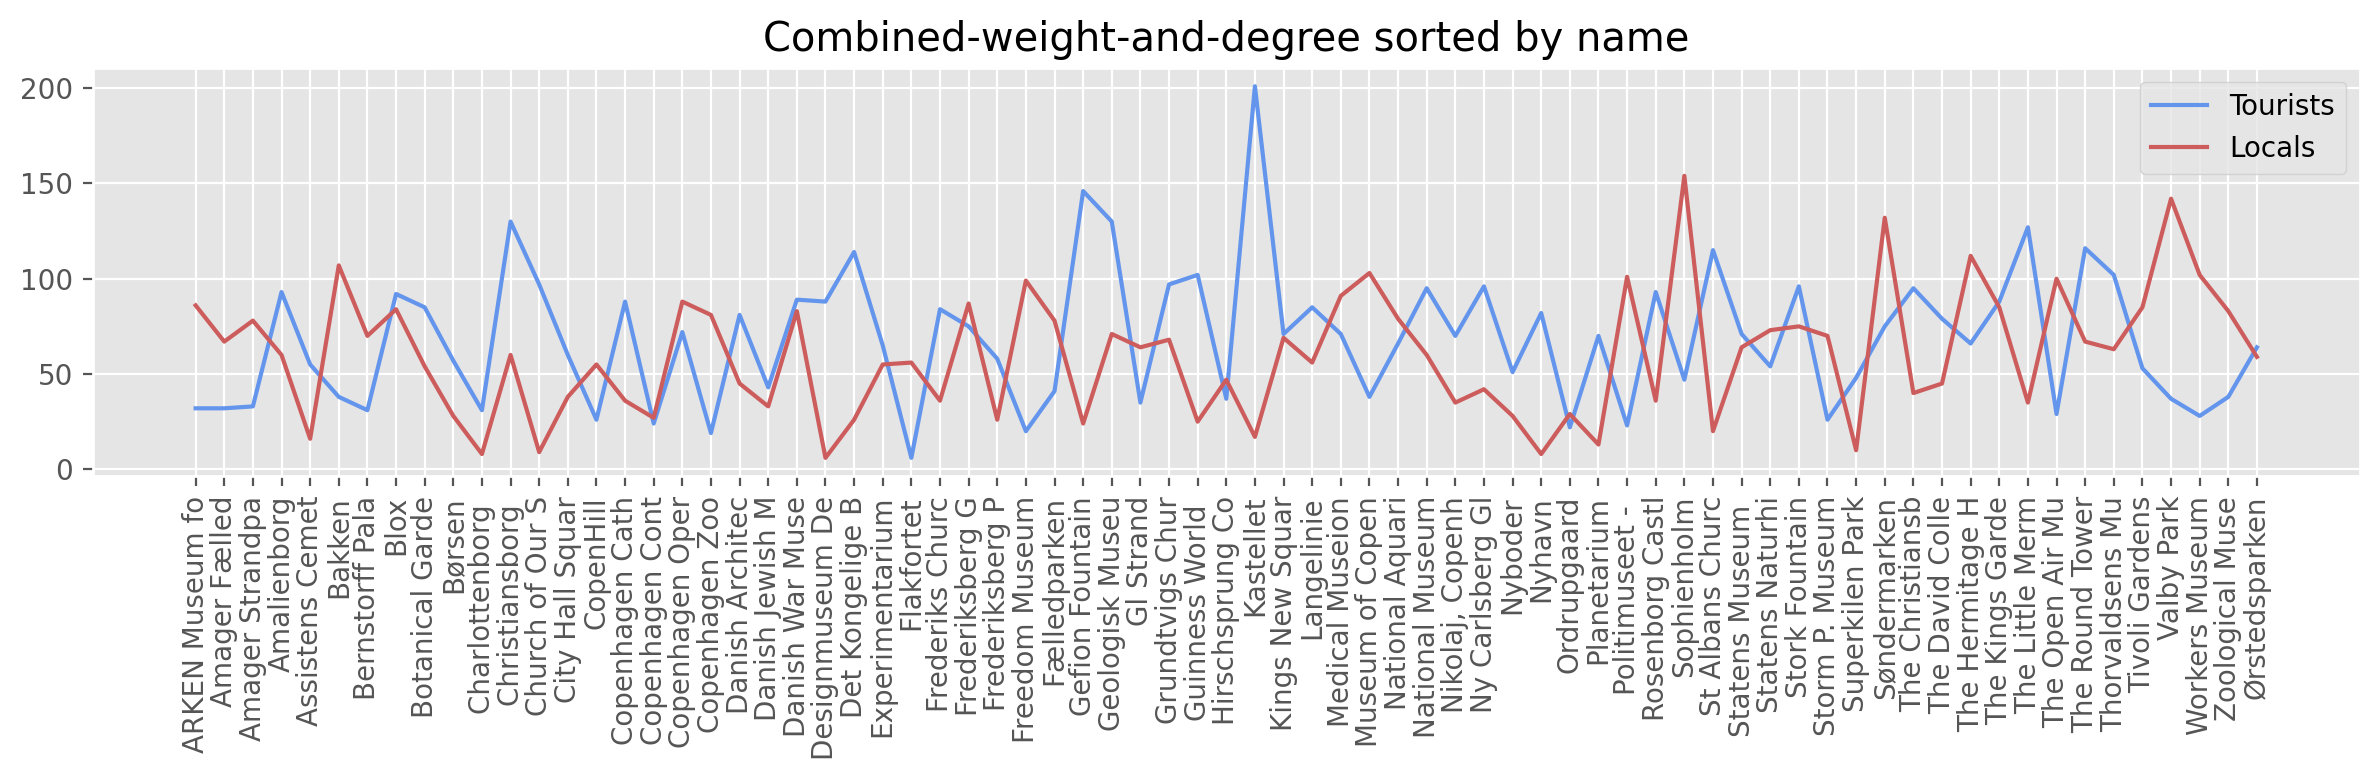

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [226]:
degree_n_weigths = [tourists_degrees, locals_degrees, random_degrees]
figure(figsize=(12, 4), dpi=200)
compare_all_degree(degree_n_weigths, name_list, color_list, sorted_by_attraction = True)
figure(figsize=(4, 4), dpi=200)

#### Some observations:
* ##### Some high interest points of locals which are of low interest for the tourists are: Bakken, Sophienholm, Freedom Museum etc
* ##### Some high interest points of tourists which are of low interest for the locals are: Gefion Fountain, Kastellet, Det Kongelige Bibliotek etc.
#### Again its apperent that the danes prefer parks and more subtle attractions where as the tourists focus on the bigger traditionel attractions. 

### We also look at their density distribution:

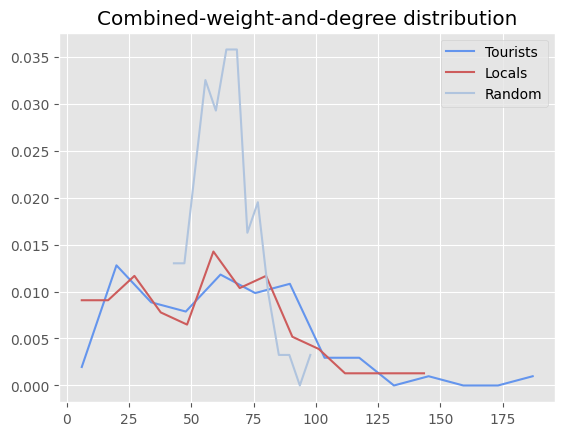

In [292]:

compare_all_degree(degree_n_weigths, name_list, color_list, sorted_by_attraction = False, hist=True)

#### This is an instance of including the random network that makes sense as it clearly shows that the random network is much more centered around some mean value and doesnt have nearly the same amount of extremes as in either the local or danes network. This demonstrates that the 2 networks are not infact just random.
#### From this plot we expected that the locals would have had a greater amount of density in the low-mid end as this would show that they had visited a wider and more diverse amount of attractions and not just the most popular onces. This does not seem to be the case, as the two distributions are very alike. Although, the opposite is true with respect to the tourists. As its clear from the density that the tourists have a greater amount of outliers in the high end, compared to the locals. This can be interpreted as the tourists having a few very central and popular attractions that they are likely to attend if they visit Denmark. 

### Lastly we could take a look at some other network properties such as the clustering coefficient and the average shortest path:

In [147]:
print("Average shortest path length in the Tourist network: ", round(nx.average_shortest_path_length(G_int),3))
print("Average shortest path length in the Local network: ", round(nx.average_shortest_path_length(G_da),3))
print("Average shortest path length in the Random network: ", round(nx.average_shortest_path_length(G_ran),3))

print("\nThe clustering coefficcient of the Tourist network is:", round(np.mean(list(nx.clustering(G_int).values())),3))
print("The clustering coefficcient of the Local network is:", round(np.mean(list(nx.clustering(G_da).values())),3))
print("The clustering coefficcient of the Random network is:", round(np.mean(list(nx.clustering(G_ran).values())),3))

Average shortest path length in the Tourist network:  1.655
Average shortest path length in the Local network:  1.705
Average shortest path length in the Random network:  1.653

The clustering coefficcient of the Tourist network is: 0.486
The clustering coefficcient of the Local network is: 0.474
The clustering coefficcient of the Random network is: 0.353


#### As expected the local and tourist network are more clustered than the random network indicating that they are infact not just random. We further see that the average shortest path for the tourist is less than for the locals, meaning that there is a greater diversity in what the tourist visit as the attractions are connected via shorter paths. We would have expected the opposite.

## One big short coming of the network analysis
#### Because we are limited to 1000 reviews per attraction we are faced with some big shortcomings with respect to the network analysis. For instance the biggest attractions such as Tivoli Gardens with 50.000+ reviews should definitely be a big interconnections in the network, but this is not the case in our networks since we only have the 1000 most recent reviews thus neglecting a lot of possible connections to or from Tivoli Gardens and therefore not properly representing Tivoli Gardens. Only having the most recent reviews will also favour the Tourists: A Tourist is likely to have visited a lot of attractions in a short span. Whereas some local might have visited overall more places, but have done so over a longer period of time. Therefore it is very likely that not all not all of the locals reviews are present in the data. Because of this big short coming all the results should be taken with a big grain of salt.

#### One work around could be to redownload all the available data from Trip Adviser which allegedly should be easy and without limitations. In order to do so all the download code and preprocessing code would have to be rewritten, which is not viable at this point.

#### Another work around for this could be to only concider attractions which has a 1000 or less reviews. This also has drawbacks since it basically removes all the attractions that tourists who visit Denmark would want to see in the first place. Futhermore it ruins big interconnections in the network, since everything is equally unpopular.

#### We did perform all the network analysis on networks which only had attractions with 1000 or less reviews but ended up going with what we have done since it felt like too much of the underlying structure was ruined by excluding the big attractions. Just for the purpose of demonstration here is what the networks look like with only sub 1000 reviews attractions. 


In [229]:
# only the following attractions where included since they have around a 1000 or less reviews:
# this list was manually picked bu looking each attraction up on google
sub_1000_reviews_list = [
    'Blox', 'The Hermitage Hunting Lodge', 'Storm P. Museum', 'St Albans Church',
    'Medical Museion', 'Flakfortet', 'Politimuseet - Danish Police Museum',
    'Freedom Museum',
    'The Christiansborgs Tower', 'Geologisk Museum',
    'Danish Jewish Museum', 'Amager Fælled',
    'Copenhagen Contemporary', 'Nyboder', 'Sophienholm', 'Bernstorff Palace',
    'Museum of Copenhagen', 'Danish War Museum', 'Assistens Cemetery',
    'Nikolaj, Copenhagen Contemporary Art Center',
    'Grundtvigs Church', 'Statens Naturhistoriske Museum', 'Gl Strand',
    'Zoological Museum', 'Workers Museum', 'CopenHill', 'Experimentarium',
    'The David Collection',
    'Charlottenborg Palace',
    'Hirschsprung Collection', 'Ordrupgaard', 'Planetarium',
    'Det Kongelige Bibliotek',
    'Børsen',
    'Frederiksberg Palace', 'Gefion Fountain'
]

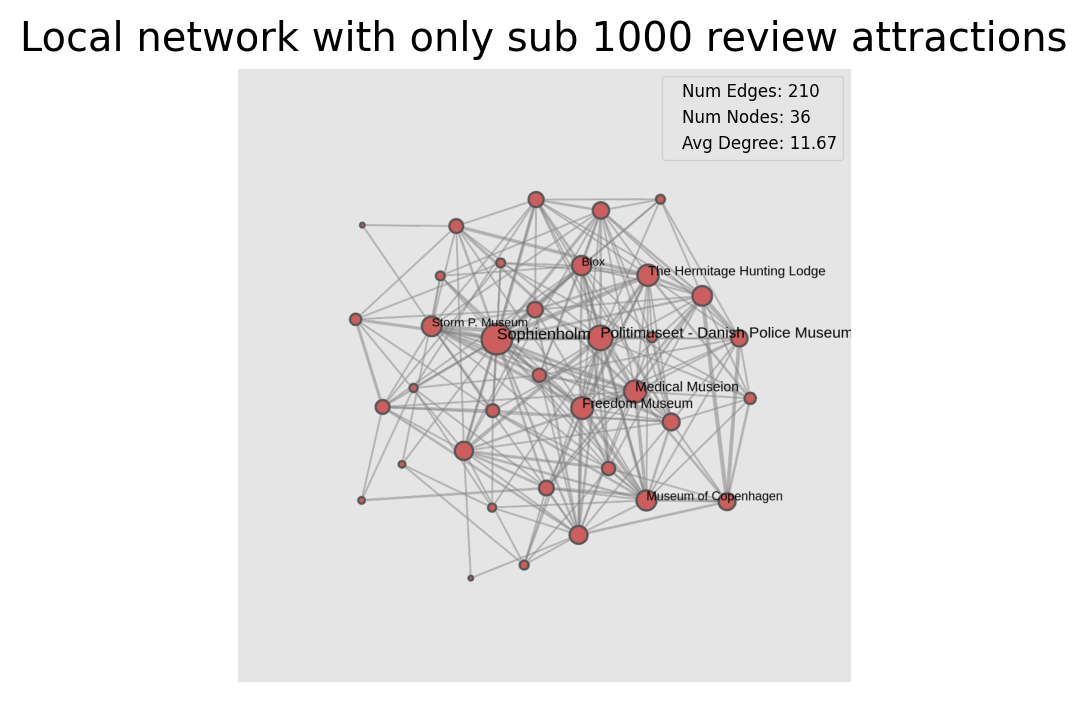

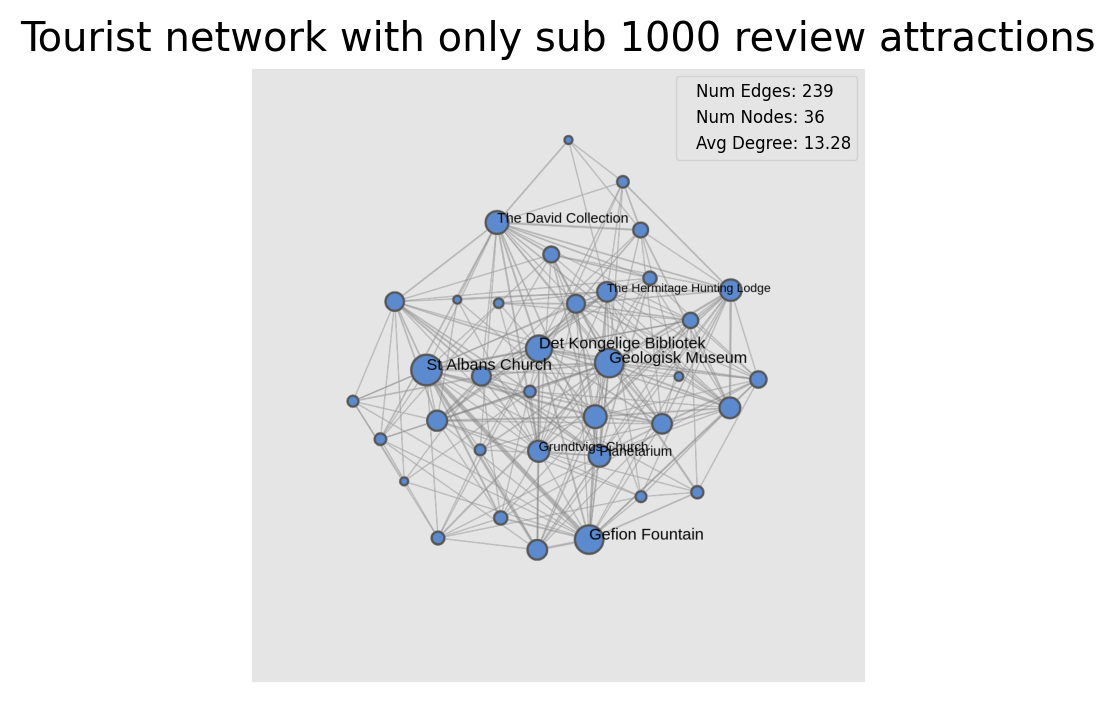

In [233]:
display_network("da_sub1000", "Local network with only sub 1000 review attractions", graph_dict_name = "graph_dict_da_sub1000")
display_network("int_sub1000", "Tourist network with only sub 1000 review attractions", graph_dict_name = "graph_dict_international_normalized_to_da_sub1000")

#### These are clearly two completly different networks compared to their earlier counterparts. If we started to analysis and interpret these, the results would most likely tell a very different story.

# Conclusion
## What we learned
The results from both the text and network analysis should be considered with some skepticism due to the already mentioned shortcomings of the data.

In the text analysis, we found a few cases of words that appeared more frequent in the tourist reviews than the local reviews and vice versa. This indiciate more specific preferences in the places the two groups visit, e.g. is tourist mentioning "time" more, which confirms the assumption that tourist want to spend time efficiently and only visit places worth the time.
We tried to compare rating with the caption sentiments, and found that a lot of reviews were found neutral, but otherwise had the same pattern as the review ratings. Through these, we saw that local reviewers gave lower ratings than tourists. We had assumptions that it would be opposite and the locals were more biased towards liking their own neighbourhood, but this was not the case.

In regards to the network, we found that the tourist network and local network were far from random and had proper underlying network structure. The structure and characteristics of the two networks very quite alike, but with vastly different nodes being center of attention in each network.
Further we found, as expected, that the tourists were more interested in the big traditionally popular glamorous places such as The Little Mermaid etc. Where as the locals were more interested in the more subtly attractions such as various parks.
Additional, we found that the most popular attractions in the eyes of the tourists were more extreme than the most popular attraction in the yes of the locals. Which was expected as it confirms that tourists have some key places they are very likely to visit when in denmark.
Lastly and contrary to prior believes we found that the attractions were more tightly connected (shorter avg shortest path) in the tourist network meaning that the tourist visits a more diverse range of attractions. Here we assumed that the locals would be better at attended a wider range of attractions, (especially the less popular) thus better tying together their network. This was not the case.

# Further Reasearch
## What to do from here
We have an idea for how this project could evolve. For the tokens of the reviews, it could be possible to categorize the tokens in groups like fun, history, family etc. to analyse what kind of goal a group of people seek when visiting Copenhagen or another specific location.

Furthermore It would be interesting to redo the network analysis with proper data which is not limited in one way or another. The data from trip adviser seems as promising candidate for this.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d44cfa22-87de-4f92-9247-7a027ec19965' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>